In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb

# output 1심장마비 위험도 높고, 0은 낮다
# trdbps 휴식시 혈압, chol 콜레스테롤, fbs 공복혈당, restecg 휴식시 심전도(1파형이상2좌심실비대), thalach 최대심박수
# exang 운동 유발 협심증, oldpeak (파형이상)휴식시 심장변화, slp 말하기증상(2심함), caa 주요혈관 수, thall 빈혈
heart = pd.read_csv('heart.csv')
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [2]:
heart['output'].value_counts()

output
1    165
0    138
Name: count, dtype: int64

In [3]:
# sns.pairplot(heart, hue='output')
# plt.show()

<Axes: >

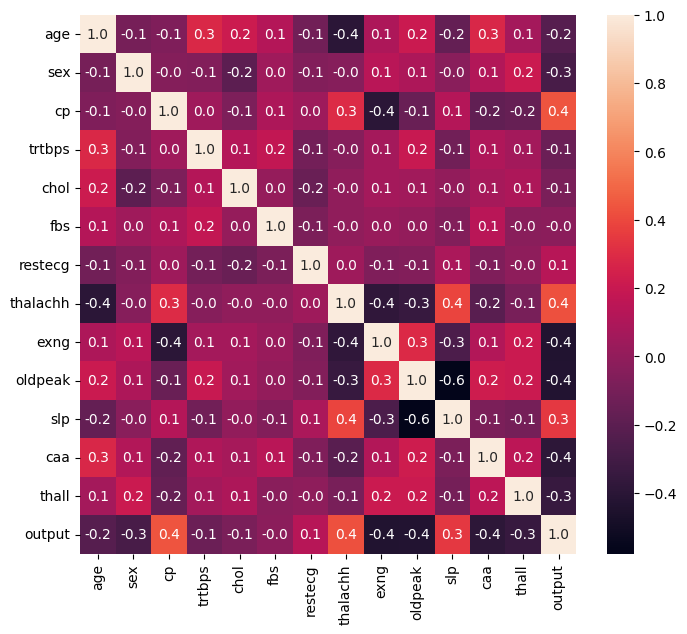

In [4]:
plt.figure(figsize=(8,7))
sns.heatmap(heart.corr(), annot=True, fmt='.1f')

In [5]:
heart.corr()['output'].abs().sort_values(ascending=False)

output      1.000000
exng        0.436757
cp          0.433798
oldpeak     0.430696
thalachh    0.421741
caa         0.391724
slp         0.345877
thall       0.344029
sex         0.280937
age         0.225439
trtbps      0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: output, dtype: float64

In [6]:
# plt.figure(figsize=(8, 3))
# sns.countplot(x='exng', hue='output', data=heart)
# plt.show()

heart_0 = heart[heart['output'] == 0]
heart_1 = heart[heart['output'] == 1]

fig = px.bar(heart_0.groupby('exng')['output'].count().reset_index(), x='exng', y='output', labels={'exng': 'exng', 'output': 'output'})
fig.add_bar(x=heart_1.groupby('exng')['output'].count().reset_index()['exng'], y=heart_1.groupby('exng')['output'].count().reset_index()['output'], name='output 1')
fig.update_layout(width=800, height=600)
fig.show()

In [7]:
# plt.figure(figsize=(8, 5))
# sns.countplot(x='caa', hue='output', data=heart)
# plt.show()

# heart[heart['output'] == 0].groupby('caa')['output'].count().plot(kind='line', marker='o', label='output=0')
# heart[heart['output'] == 1].groupby('caa')['output'].count().plot(kind='line', marker='o', label='output=1')
# plt.legend()
# plt.show()

fig = px.line(heart_0.groupby('caa')['output'].count().reset_index(), x='caa', y='output', labels={'caa': 'caa', 'output': 'output'})
fig.add_scatter(x=heart_0.groupby('caa')['output'].count().reset_index()['caa'], y=heart_0.groupby('caa')['output'].count().reset_index()['output'], mode='lines+markers', name='output 0')
fig.add_scatter(x=heart_1.groupby('caa')['output'].count().reset_index()['caa'], y=heart_1.groupby('caa')['output'].count().reset_index()['output'], mode='lines+markers', name='output 1')
fig.update_layout(width=800, height=600)
fig.show()

In [8]:
# oldpeak     0.430696
# thalachh    0.421741
# caa         0.391724
# plt.figure(figsize=(8, 5))

# heart_0 = heart[heart['output'] == 0]
# heart_1 = heart[heart['output'] == 1]

# plt.scatter(x='oldpeak', y='thalachh', c='red', data=heart_0, label='output 0')
# plt.scatter(x='oldpeak', y='thalachh', c='blue', data=heart_1, label='output 1', marker='x')

# plt.xlabel('oldpeak')
# plt.ylabel('thalachh')
# plt.legend()
# plt.show()


fig = px.scatter(heart_0, x='oldpeak', y='thalachh', color='output', labels={'oldpeak': 'oldpeak', 'thalachh': 'thalachh'})
fig.add_scatter(x=heart_1['oldpeak'], y=heart_1['thalachh'], mode='markers', marker=dict(color='blue', symbol='x'), name='output 1')
fig.update_layout(width=800, height=600)
fig.show()

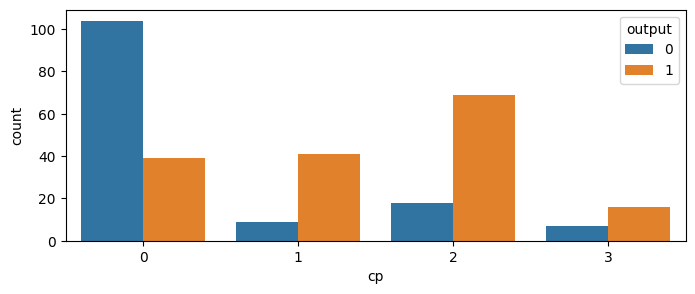

In [9]:
plt.figure(figsize=(8, 3))
sns.countplot(x='cp', hue='output', data=heart)
plt.show()


fig = px.bar(heart_0.groupby('cp')['output'].count().reset_index(), x='cp', y='output', labels={'cp': 'cp', 'output': 'output'})
fig.add_bar(x=heart_1.groupby('cp')['output'].count().reset_index()['cp'], y=heart_1.groupby('cp')['output'].count().reset_index()['output'], name='output 1')
fig.update_layout(width=800, height=600)
fig.show()

In [10]:
heart.iloc[:, :-1].corr().unstack().abs().sort_values(ascending=False).iloc[10:30]

cp        cp          1.000000
restecg   restecg     1.000000
thall     thall       1.000000
slp       oldpeak     0.577537
oldpeak   slp         0.577537
age       thalachh    0.398522
thalachh  age         0.398522
cp        exng        0.394280
exng      cp          0.394280
slp       thalachh    0.386784
thalachh  slp         0.386784
exng      thalachh    0.378812
thalachh  exng        0.378812
oldpeak   thalachh    0.344187
thalachh  oldpeak     0.344187
cp        thalachh    0.295762
thalachh  cp          0.295762
exng      oldpeak     0.288223
oldpeak   exng        0.288223
age       trtbps      0.279351
dtype: float64

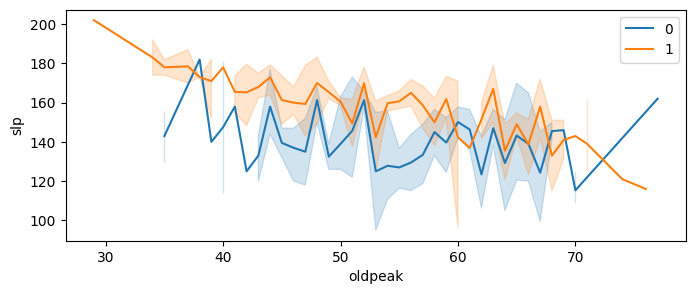

In [11]:
plt.figure(figsize=(8, 3))
sns.lineplot(x='age', y='thalachh', data=heart, hue='output')
plt.xlabel('oldpeak')
plt.ylabel('slp')
plt.legend()
plt.show()

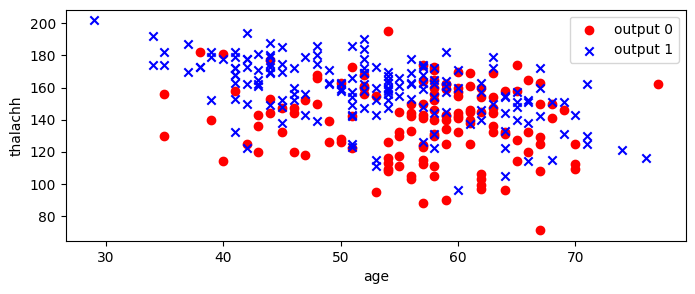

In [12]:
plt.figure(figsize=(8, 3))
plt.scatter(x='age', y='thalachh', c='red', data=heart_0, label='output 0')
plt.scatter(x='age', y='thalachh', c='blue', data=heart_1, label='output 1', marker='x')
plt.xlabel('age')
plt.ylabel('thalachh')
plt.legend()
plt.show()

fig = px.scatter(heart_0, x='age', y='thalachh', color='output', labels={'age': 'age', 'thalachh': 'thalachh'})
fig.add_scatter(x=heart_1['age'], y=heart_1['thalachh'], mode='markers', marker=dict(color='blue', symbol='x'), name='output 1')
fig.update_layout(width=800, height=600)
fig.show()

In [83]:
# output      1.000000
# exng        0.436757
# cp          0.433798
# oldpeak     0.430696
# thalachh    0.421741
# caa         0.391724
# slp         0.345877
# thall       0.344029
# sex         0.280937
# age         0.225439
# trtbps      0.144931
# restecg     0.137230
# chol        0.085239
# fbs         0.028046

X = heart.iloc[:, :-1]
y = heart.iloc[:, -1]

X = X.drop(['trtbps', 'restecg', 'chol', 'fbs', 'age', 'sex'], axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train

,cp,thalachh,exng,oldpeak,slp,caa,thall
34,3,125,1,1.4,2,1,2
185,0,153,0,0.0,2,1,2
187,0,109,1,2.2,1,1,3
147,3,171,0,0.9,2,0,2
202,0,111,1,0.8,2,0,3
...,...,...,...,...,...,...,...
203,2,150,1,1.6,1,0,3
255,0,147,1,0.0,1,3,3
72,1,202,0,0.0,2,0,2
235,0,173,1,1.6,2,0,3


In [85]:
std = StandardScaler()
std_scaler_col = ['thalachh']
X_train[std_scaler_col] = std.fit_transform(X_train[std_scaler_col])
X_test[std_scaler_col] = std.transform(X_test[std_scaler_col])

mM_scaler = MinMaxScaler()
mM_scaler_col = ['oldpeak', 'caa', 'thall', 'slp', 'cp']
X_train[mM_scaler_col] = mM_scaler.fit_transform(X_train[mM_scaler_col])
X_test[mM_scaler_col] = mM_scaler.transform(X_test[mM_scaler_col])

X_train

,cp,thalachh,exng,oldpeak,slp,caa,thall
34,1.000000,-1.074173,1,0.250000,1.0,0.25,0.666667
185,0.000000,0.121905,0,0.000000,1.0,0.25,0.666667
187,0.000000,-1.757646,1,0.392857,0.5,0.25,1.000000
147,1.000000,0.890812,0,0.160714,1.0,0.00,0.666667
202,0.000000,-1.672212,1,0.142857,1.0,0.00,1.000000
...,...,...,...,...,...,...,...
203,0.666667,-0.006246,1,0.285714,0.5,0.00,1.000000
255,0.000000,-0.134398,1,0.000000,0.5,0.75,1.000000
72,0.333333,2.215041,0,0.000000,1.0,0.00,0.666667
235,0.000000,0.976246,1,0.285714,1.0,0.00,1.000000


# 모델과 파라미터 찾기

In [41]:
# 서로 다른 모델들 간에 또 최적을 찾기
lr_gs = GridSearchCV(estimator=LogisticRegression(), 
                     param_grid={'C': [0.1, 1, 10]}, 
                     cv=2)
svc_gs = GridSearchCV(estimator=SVC(), 
                      param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}, 
                      cv=2)
forest_gs = GridSearchCV(estimator=RandomForestClassifier(), 
                         param_grid={'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15],
                                     'n_estimators': [100, 300, 500],
                                    'max_depth': [2, 4, 6, 8],
                                    'min_samples_split': [2, 4, 6],
                                    'min_samples_leaf': [1, 2, 4]}, 
                         cv=2)
xgb_gs = GridSearchCV(estimator=xgb.XGBClassifier(), 
                      param_grid={'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1, 0.15], 'objective': ['binary:logistic']}, 
                      cv=2)

lr_gs.fit(X_train, y_train)
svc_gs.fit(X_train, y_train)
forest_gs.fit(X_train, y_train)
xgb_gs.fit(X_train, y_train)

lr_score = cross_val_score(estimator=lr_gs, X=X_train, y=y_train, cv=5)
svc_score = cross_val_score(estimator=svc_gs, X=X_train, y=y_train, cv=5)
forest_score = cross_val_score(estimator=forest_gs, X=X_train, y=y_train, cv=5)
xgb_score = cross_val_score(estimator=xgb_gs, X=X_train, y=y_train, cv=5)

# 가장 좋은 best_model과 그 모델의 best_params 출력
best_score = np.argmax([lr_score.mean(), svc_score.mean(), forest_score.mean(), xgb_score.mean()])
if best_score == 0:
    best_model = lr_gs
    best_params = lr_gs.best_params_
elif best_score == 1:
    best_model = svc_gs
    best_params = svc_gs.best_params_
elif best_score == 2:
    best_model = forest_gs
    best_params = forest_gs.best_params_
else:
    best_model = xgb_gs
    best_params = xgb_gs.best_params_

print("Best model:", best_model)
print("Best parameters:", best_params)

Best model: GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     m

In [50]:
# XGBoost 분류기 모델을 생성합니다.
model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, objective='binary:logistic')

# 모델을 학습 데이터셋에 적합시킵니다.
model.fit(X_train, y_train)

# 테스트 데이터셋에 대한 예측을 수행합니다.
predictions = model.predict(X_test)

# 성능을 평가합니다.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.43%


In [51]:
# 모델 평가
p_test = model.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))

F1-score: 0.7547169811320756
[[25 16]
 [10 40]]


# 선정된 모델 파라미터 다시 찾기

In [62]:
xgb_pipe = make_pipeline(xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1))
param_grid = {'xgbclassifier__max_depth': [3, 5, 7],
              'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.15],
              'xgbclassifier__n_estimators': [100, 300, 500],
              'xgbclassifier__min_child_weight': [1, 3, 5],
              'xgbclassifier__colsample_bytree': [0.5, 0.7],
              'xgbclassifier__reg_alpha': [0, 0.03, 0.1],
              'xgbclassifier__reg_lambda': [0.1, 0.5, 1],
              'xgbclassifier__objective': ['binary:logistic']}

gs = GridSearchCV(estimator=xgb_pipe, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [63]:
# 얘는 학습결과를 덮어써야 함.
gs = gs.fit(X_train, y_train)

In [64]:
gs.best_score_

0.8831168831168832

In [65]:
gs.best_estimator_

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=1, ...))])

In [66]:
gs.best_params_

{'xgbclassifier__colsample_bytree': 0.7,
 'xgbclassifier__learning_rate': 0.01,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__min_child_weight': 3,
 'xgbclassifier__n_estimators': 300,
 'xgbclassifier__objective': 'binary:logistic',
 'xgbclassifier__reg_alpha': 0,
 'xgbclassifier__reg_lambda': 0.1}

In [86]:
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1, colsample_bytree=0.7, 
                        learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=0.1)
xgb.fit(X_train, y_train)

p_test = xgb.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))

F1-score: 0.7843137254901961


In [87]:
# 모델 평가
p_test = xgb.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))

F1-score: 0.7843137254901961
[[29 12]
 [10 40]]


In [88]:
cvscore = cross_val_score(estimator=xgb, X=X_train, y=y_train, cv=10, n_jobs=-1) # 10조각(kfold)
print('\n교차검증(CV) 정확도 : ', np.mean(cvscore))
for i, j in enumerate(cvscore):
    print(f'{i+1}번 : {j}')


교차검증(CV) 정확도 :  0.8831168831168832
1번 : 0.8181818181818182
2번 : 0.7272727272727273
3번 : 0.7619047619047619
4번 : 0.9047619047619048
5번 : 0.9523809523809523
6번 : 0.8571428571428571
7번 : 0.9047619047619048
8번 : 1.0
9번 : 1.0
10번 : 0.9047619047619048


# 학습곡선

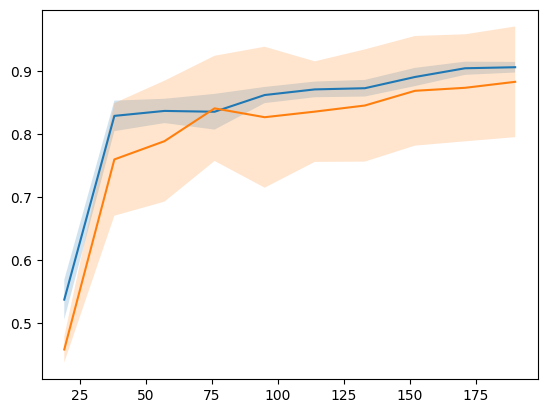

In [89]:
from sklearn.model_selection import learning_curve

sizes, train_score, val_score = learning_curve(estimator=xgb, X=X_train, y=y_train, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.show()

# 검증곡선

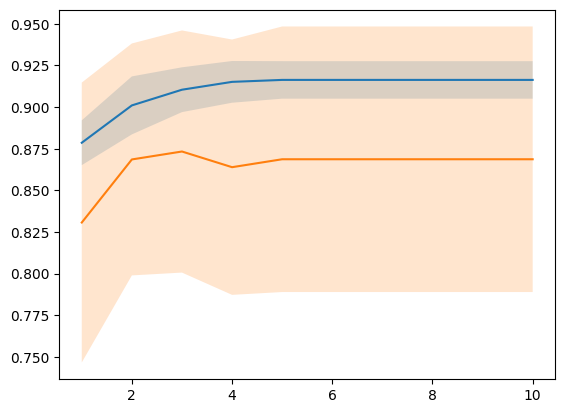

In [90]:
from sklearn.model_selection import validation_curve

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = validation_curve(
    xgb, X_train, y_train, param_name="max_depth", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(param_range, train_mean)
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(param_range, test_mean)
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.2)

plt.show()

# ROC

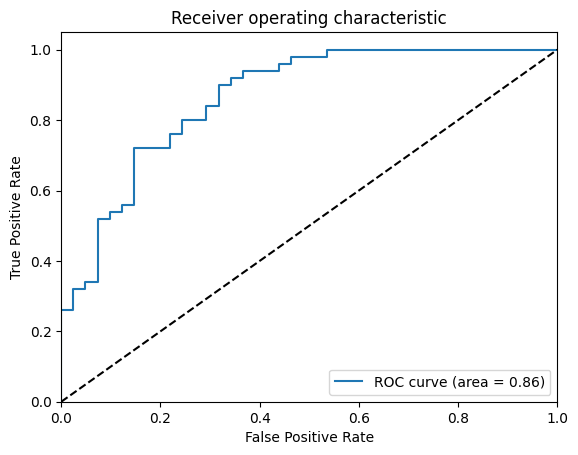

In [91]:
prob = xgb.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc = roc_auc_score(y_test, prob[:,1])

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [92]:
from sklearn.model_selection import GridSearchCV

rf_pipe = make_pipeline(RandomForestClassifier(criterion='gini', random_state=1, n_jobs=-1))
param_grid = {'randomforestclassifier__n_estimators': [100, 300, 500],
              'randomforestclassifier__max_depth': [2, 4, 6, 8],
              'randomforestclassifier__min_samples_split': [2, 4, 6],
              'randomforestclassifier__min_samples_leaf': [1, 2, 4]}

gs = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [93]:
# 얘는 학습결과를 덮어써야 함.
gs = gs.fit(X_train, y_train)

In [94]:
gs.best_score_

0.869047619047619

In [95]:
gs.best_estimator_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_split=6,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=1))])

In [96]:
gs.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 6,
 'randomforestclassifier__n_estimators': 500}

In [97]:
forest = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=500, random_state=1, n_jobs=-1,
                                            min_samples_split=6, min_samples_leaf=1)
model = forest.fit(X_train, y_train)
p_val = forest.predict(X_test)
score = f1_score(y_test, p_val)

print('Best F1-score:', score)

Best F1-score: 0.796116504854369


In [98]:
# 모델 평가
p_test = forest.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))

F1-score: 0.796116504854369
[[29 12]
 [ 9 41]]


# 교차검증

In [99]:
from sklearn.model_selection import cross_val_score

cvscore = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10, n_jobs=-1) # 10조각(kfold)
print('\n교차검증(CV) 정확도 : ', np.mean(cvscore))
for i, j in enumerate(cvscore):
    print(f'{i+1}번 : {j}')


교차검증(CV) 정확도 :  0.869047619047619
1번 : 0.7727272727272727
2번 : 0.7272727272727273
3번 : 0.7619047619047619
4번 : 0.9047619047619048
5번 : 0.9523809523809523
6번 : 0.8095238095238095
7번 : 0.8571428571428571
8번 : 1.0
9번 : 1.0
10번 : 0.9047619047619048


# 학습곡선

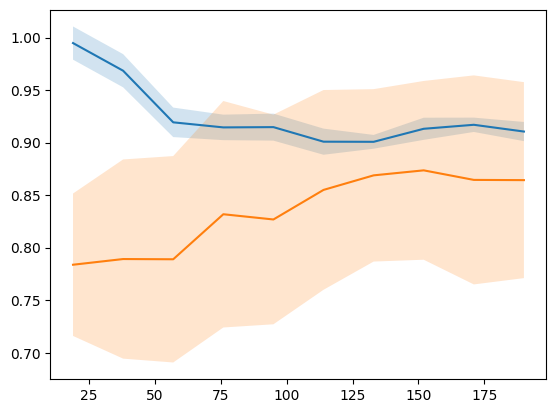

In [100]:
from sklearn.model_selection import learning_curve

sizes, train_score, val_score = learning_curve(estimator=forest, X=X_train, y=y_train, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.show()

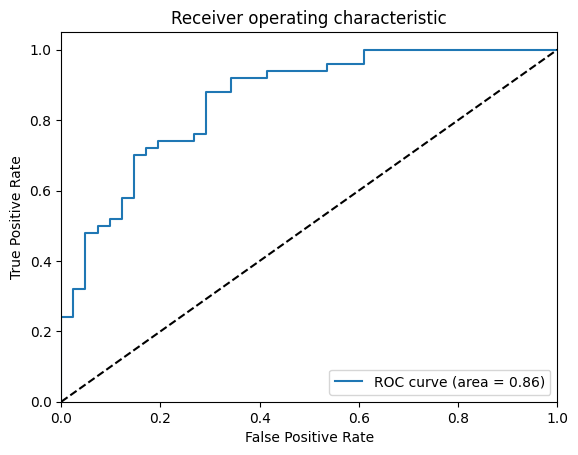

In [103]:
prob = forest.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc = roc_auc_score(y_test, prob[:,1])

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()